<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-nnqf.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-nnqf.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb&fileName=gefcom14-s-nnqf"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Download data

In [ ]:
!echo "Downloading GEFCom14-S..."
!rm -R data > /dev/null
!wget -O gefcom14.zip https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0
!unzip gefcom14 > /dev/null
!rm gefcom14.zip > /dev/null
!unzip GEFCom2014\ Data/GEFCom2014-S_V2.zip > /dev/null
!rm -R GEFCom2014\ Data > /dev/null
!mv Solar data > /dev/null
!echo "------------------------------"
!echo "Downloaded GEFCom14-S in data/"

# Select Task

In [2]:
task = 9

# Prepare data

In [3]:
import numpy as np
import pandas as pd

predictors = pd.read_csv(f'data/Task {task}/predictors{task}.csv', parse_dates=['TIMESTAMP'])\
    [['ZONEID', 'TIMESTAMP', 'VAR164', 'VAR169', 'VAR175', 'VAR178', 'VAR228']].set_index('TIMESTAMP')
train = pd.read_csv(f'data/Task {task+1}/train{task+1}.csv', parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')
benchmark = pd.read_csv(f"data/Task {task}/benchmark{'0' + str(task) if task < 10 else task}.csv",
                        parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')

solar_plants = [train[train['ZONEID'] == i][['POWER']].rename({'POWER': f'ZONEID {i}'}, axis='columns')
                for i in [1,2,3]]
train_data = pd.concat(solar_plants, axis=1)

predictors['VAR164*169'] = predictors['VAR164'] * predictors['VAR169']

predictors_categories = [predictors[predictors['ZONEID'] == i][['VAR169', 'VAR175', 'VAR178', 'VAR228', 'VAR164*169']]
                             .rename({'VAR169': f'SSRD {i}',
                                      'VAR175': f'STRD {i}',
                                      'VAR178': f'TSR {i}', 
                                      'VAR228': f'TP {i}',
                                      'VAR164*169': f'TCC*SSRD {i}'}, axis='columns')
                         for i in [1,2,3]]
predictor_data = pd.concat(predictors_categories, axis=1)

In [4]:
gefcom14_metadata = {
    'num_series': 3,
    'num_steps': len(predictor_data),
    'prediction_length': len(benchmark) // 3,
    'start': predictor_data.index[0]
}

In [5]:
for i in range(1, 4):
    predictor_data[f'SSRD {i}'] /= predictor_data[f'SSRD {i}'].max()
    predictor_data[f'STRD {i}'] /= predictor_data[f'STRD {i}'].max()
    predictor_data[f'TSR {i}'] /= predictor_data[f'TSR {i}'].max()
    predictor_data[f'TP {i}'] /= predictor_data[f'TP {i}'].max()
    predictor_data[f'TCC*SSRD {i}'] /= predictor_data[f'TCC*SSRD {i}'].max()

In [6]:
predictor_zones = []
train_data_zones = []

for zoneid in range(1, 4):
    predictor = predictor_data[[f'SSRD {zoneid}', f'STRD {zoneid}', f'TSR {zoneid}', f'TP {i}', f'TCC*SSRD {i}']]
    predictor_zones.append(predictor)
    train_data_zone = train_data[[f'ZONEID {zoneid}']]
    train_data_zones.append(train_data_zone)

In [7]:
x_input_zones = []
y_output_zones = []

for predictor, train_data in zip(predictor_zones, train_data_zones):
    x_input_df = predictor[:-gefcom14_metadata['prediction_length']]
    x_input = np.array(x_input_df)
    x_input_zones.append(x_input)
    y_output = np.array(train_data[:-gefcom14_metadata['prediction_length']])
    y_output_zones.append(y_output)

# NNQF

In [8]:
import numpy as np
from sklearn.neighbors import NearestNeighbors as nn_fun

def nnqf_filter(x_input, 
                y_output, 
                num_neighbors = 10, 
                q_quantile = 0.5, 
                var_weighting = True, 
                minkowski_dist = 2):
    """
    Parameters
    ----------
    x_input : numpy array ;
    Input matrix of dimension (N,S), with N representing the number of
    samples and S the number of features

    y_output : numpy array ;
    Output vector of dimension (N,)

    num_neighbors : int, default = 10 ;
    Number of nearest neighbors that the filter is going to search for     

    q_quantile : float, default = 0.5 ;
    Must be a value between 0 and 1. 
    Probability of the quantile that is going to be calculated from the 
    nearest neighbors output values      

    var_weighting : bool, default = True ;
    Value defining if the columns of the input matrix are going to be multiplied 
    by the inverse of their variance

    minkowski_dist : int, default = 2 ;
    Parameter used to define the type of minkoswki distance used to calculate 
    the nearest neighbors

    Returns
    -------
    yq_output : numpy array ;
    New output vector containing the quantiles of the output values of the
    input's nearest neighbors

    """
    # --
    # Each column of the input matrix is multiplied by the inverse of its variance, 
    # in order to avoid a feature with a huge scale to overpower the others at the 
    # moment of calculating the distances

    if var_weighting:
        var_weights = np.var(x_input, axis=0)
        x_input = var_weights ** (-1) * x_input    

    # --
    # We calculate the nearest neighbor of each feature vector within the input matrix
    # and obtain their corresponding indices
    # The distance used is the minkowski distance with p = minkowski_dist

    x_neighbors = nn_fun(n_neighbors=num_neighbors, algorithm='auto', p=minkowski_dist).fit(x_input)
    dist, indx = x_neighbors.kneighbors(x_input)


    # --
    # We create a matrix containing the output values of nearest neighbors of
    # each input vector

    y_neighbors = y_output[indx[0,:]].T
    for i in range(1, np.size(x_input, 0)):
        values_to_add = y_output[indx[i,:]].T
        y_neighbors = np.vstack([y_neighbors, values_to_add])

    # --
    # We calculate the q_quantile of the nearest neighbors output values
    # and create with them a new output vector yq_output

    yq_output = np.quantile(y_neighbors, q=q_quantile, axis=1)
        
    return yq_output

In [9]:
from tqdm import tqdm

yq_output_zones = []

for x_input, y_output in tqdm(zip(x_input_zones, y_output_zones)):
    yq_output = nnqf_filter(x_input=x_input, y_output=y_output,
                            q_quantile=[p / 100 for p in range(1, 100)],
                            num_neighbors=100).T
    yq_output_df = pd.DataFrame(yq_output, index=x_input_df.index)\
        .rename(columns={p: str((p+1)/100) for p in range(99)})
    yq_output_zones.append(yq_output_df)

3it [01:09, 23.24s/it]


# Train the linear regression model (ANN6)

In [10]:
for zoneid in range(1, 4):
    # remove timecode
    predictor = predictor_zones[zoneid-1].reset_index().drop('TIMESTAMP', axis=1).rename(columns={
        f'SSRD {zoneid}': 0,
        f'STRD {zoneid}': 1,
        f'TSR {zoneid}': 2, 
        f'TP {zoneid}': 3,
        f'TCC*SSRD {zoneid}': 4})
    predictor_zones[zoneid-1] = predictor

predictor_zones[0]

,0,1,2,TP 3,TCC*SSRD 3
0,0.075407,0.035187,0.076927,0.000000,0.018727
1,0.156676,0.071594,0.159924,0.013823,0.090693
2,0.231728,0.107719,0.240292,0.029863,0.153982
3,0.288440,0.144007,0.304604,0.037236,0.273252
4,0.325958,0.183008,0.352287,0.045280,0.315048
...,...,...,...,...,...
15355,0.744551,0.684306,0.734685,0.001926,0.515584
15356,0.772470,0.718138,0.766252,0.001926,0.450867
15357,0.825222,0.751265,0.820998,0.001926,0.835361
15358,0.897001,0.786016,0.894231,0.001926,0.878349


## Prepare data for regression model

In [11]:
h = 24
h1 = 24

x_zones = []

for predictor in predictor_zones:
    x_pieces = []
    for i in range(h1):
        piece = predictor.drop(range(i)).reset_index().drop('index', axis=1)\
            .rename(columns={0: f't-{h1 - i - 1}: 0',
                             1: f't-{h1 - i - 1}: 1',
                             2: f't-{h1 - i - 1}: 2'})
        x_pieces.insert(0, piece)

    x = pd.concat(x_pieces, axis=1)
    x.index = x.index.map(lambda x: x + h1 - 1)
    x = x[:-h+1]
    x_zones.append(x)

x_zones[0]

,t-0: 0,t-0: 1,t-0: 2,TP 3,TCC*SSRD 3,t-1: 0,t-1: 1,t-1: 2,TP 3,TCC*SSRD 3,t-2: 0,t-2: 1,t-2: 2,TP 3,TCC*SSRD 3,t-3: 0,t-3: 1,t-3: 2,TP 3,TCC*SSRD 3,t-4: 0,t-4: 1,t-4: 2,TP 3,TCC*SSRD 3,t-5: 0,t-5: 1,t-5: 2,TP 3,TCC*SSRD 3,t-6: 0,t-6: 1,t-6: 2,TP 3,TCC*SSRD 3,t-7: 0,t-7: 1,t-7: 2,TP 3,TCC*SSRD 3,...,t-16: 0,t-16: 1,t-16: 2,TP 3,TCC*SSRD 3,t-17: 0,t-17: 1,t-17: 2,TP 3,TCC*SSRD 3,t-18: 0,t-18: 1,t-18: 2,TP 3,TCC*SSRD 3,t-19: 0,t-19: 1,t-19: 2,TP 3,TCC*SSRD 3,t-20: 0,t-20: 1,t-20: 2,TP 3,TCC*SSRD 3,t-21: 0,t-21: 1,t-21: 2,TP 3,TCC*SSRD 3,t-22: 0,t-22: 1,t-22: 2,TP 3,TCC*SSRD 3,t-23: 0,t-23: 1,t-23: 2,TP 3,TCC*SSRD 3
23,0.452377,0.841801,0.516008,0.050869,0.378268,0.408520,0.801708,0.465510,0.050622,0.260926,0.378740,0.764677,0.429557,0.050392,0.176193,0.363237,0.728737,0.409672,0.049975,0.190325,0.361300,0.696125,0.406237,0.049549,0.177183,0.361300,0.661847,0.406237,0.049216,0.220649,0.361300,0.626774,0.406237,0.048978,0.211831,0.361300,0.591876,0.406237,0.048799,0.183666,...,0.361300,0.293813,0.406247,0.048126,0.221479,0.359056,0.257455,0.401204,0.047402,0.214586,0.345634,0.221166,0.381666,0.046618,0.270369,0.325958,0.183008,0.352287,0.045280,0.315048,0.288440,0.144007,0.304604,0.037236,0.273252,0.231728,0.107719,0.240292,0.029863,0.153982,0.156676,0.071594,0.159924,0.013823,0.090693,0.075407,0.035187,0.076927,0.000000,0.018727
24,0.050250,0.038432,0.058629,0.002526,0.028969,0.452377,0.841801,0.516008,0.050869,0.378268,0.408520,0.801708,0.465510,0.050622,0.260926,0.378740,0.764677,0.429557,0.050392,0.176193,0.363237,0.728737,0.409672,0.049975,0.190325,0.361300,0.696125,0.406237,0.049549,0.177183,0.361300,0.661847,0.406237,0.049216,0.220649,0.361300,0.626774,0.406237,0.048978,0.211831,...,0.361300,0.329398,0.406247,0.048450,0.182086,0.361300,0.293813,0.406247,0.048126,0.221479,0.359056,0.257455,0.401204,0.047402,0.214586,0.345634,0.221166,0.381666,0.046618,0.270369,0.325958,0.183008,0.352287,0.045280,0.315048,0.288440,0.144007,0.304604,0.037236,0.273252,0.231728,0.107719,0.240292,0.029863,0.153982,0.156676,0.071594,0.159924,0.013823,0.090693
25,0.097294,0.077850,0.116198,0.003768,0.057433,0.050250,0.038432,0.058629,0.002526,0.028969,0.452377,0.841801,0.516008,0.050869,0.378268,0.408520,0.801708,0.465510,0.050622,0.260926,0.378740,0.764677,0.429557,0.050392,0.176193,0.363237,0.728737,0.409672,0.049975,0.190325,0.361300,0.696125,0.406237,0.049549,0.177183,0.361300,0.661847,0.406237,0.049216,0.220649,...,0.361300,0.364594,0.406247,0.048654,0.133399,0.361300,0.329398,0.406247,0.048450,0.182086,0.361300,0.293813,0.406247,0.048126,0.221479,0.359056,0.257455,0.401204,0.047402,0.214586,0.345634,0.221166,0.381666,0.046618,0.270369,0.325958,0.183008,0.352287,0.045280,0.315048,0.288440,0.144007,0.304604,0.037236,0.273252,0.231728,0.107719,0.240292,0.029863,0.153982
26,0.149998,0.118249,0.177444,0.004124,0.091984,0.097294,0.077850,0.116198,0.003768,0.057433,0.050250,0.038432,0.058629,0.002526,0.028969,0.452377,0.841801,0.516008,0.050869,0.378268,0.408520,0.801708,0.465510,0.050622,0.260926,0.378740,0.764677,0.429557,0.050392,0.176193,0.363237,0.728737,0.409672,0.049975,0.190325,0.361300,0.696125,0.406237,0.049549,0.177183,...,0.361300,0.397944,0.406237,0.048705,0.047163,0.361300,0.364594,0.406247,0.048654,0.133399,0.361300,0.329398,0.406247,0.048450,0.182086,0.361300,0.293813,0.406247,0.048126,0.221479,0.359056,0.257455,0.401204,0.047402,0.214586,0.345634,0.221166,0.381666,0.046618,0.270369,0.325958,0.183008,0.352287,0.045280,0.315048,0.288440,0.144007,0.304604,0.037236,0.273252
27,0.202837,0.157717,0.237863,0.004302,0.101396,0.149998,0.118249,0.177444,0.004124,0.091984,0.097294,0.077850,0.116198,0.003768,0.057433,0.050250,0.038432,0.058629,0.002526,0.028969,0.452377,0.841801,0.516008,0.050869,0.378268,0.408520,0.801708,0.465510,0.050622,0.260926,0.378740,0.764677,0.429557,0.050392,0.176193,0.363237,0.728737,0.409672,0.049975,0.190325,...,0.361300,0.430853,0.406237,0.048705,0.000000,0.361300,0.397944,0.406237,0.048705,0.047163,0.361300,0.364

## Feature selection

In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

x_new_zones = []

for x, yq_output_df in zip(x_zones, yq_output_zones):
    x_select = x[:-gefcom14_metadata['prediction_length'] + 23]
    y_select = yq_output_df[str(0.5)]

    print(x_select.shape)
    print(y_select.shape)

    support = SelectKBest(f_regression, k=50).fit(x_select, y_select).get_support(indices=True)
    print(support)

    x_new = x.loc[:, x.columns[support]]
    x_new_zones.append(x_new)

(14616, 120)
(14616,)
[  1  11  15  16  17  20  21  22  25  26  27  30  31  32  35  36  37  40
  41  42  45  46  47  50  51  52  55  57  60  62  65  67  70  72  75  81
  86  91  96 101 106 107 110 111 112 114 115 116 117 119]
(14616, 120)
(14616,)
[  0   1   2  16  21  25  26  27  30  31  32  35  36  37  40  41  42  45
  46  47  50  51  52  55  56  57  60  62  65  67  70  72  75  77  80  81
  82  85  86  87  91  96 101 106 111 112 115 116 117 119]
(14616, 120)
(14616,)
[  1  11  16  20  21  22  25  26  27  30  31  32  35  36  37  40  41  42
  45  46  47  50  51  52  55  57  60  62  65  67  70  72  75  76  77  80
  81  86  91  96 101 106 110 111 112 114 115 116 117 119]


In [13]:
# x_normalized = (x_new - x_new.mean()) / x_new.std()
# x_normalized

# Training

In [14]:
from sklearn.neural_network import MLPRegressor
from tqdm import tqdm

ensemble_size = 7

predictions_zones = []

for x_new, yq_output_df in zip(x_new_zones, yq_output_zones):
    predictions = [pd.DataFrame() for _ in range(ensemble_size)]

    for p in tqdm(range(1, 100)):
        for prediction in predictions:
            y_train = yq_output_df.reset_index().drop('TIMESTAMP', axis=1).drop(range(h1-1))[str(p/100)]
            x_train = x_new[:-gefcom14_metadata['prediction_length']]
            x_predict = x_new[-gefcom14_metadata['prediction_length']:]

            model = MLPRegressor(hidden_layer_sizes=(20,10,))

            trained = model.fit(x_train, y_train)
            prediction.insert(p-1, str(p/100), trained.predict(x_predict))
    predictions_zones.append(predictions)

100%|██████████| 99/99 [31:59<00:00, 19.39s/it]


In [15]:
predictions_zones[0][0]

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4,...,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
0,0.160120,0.162530,0.306199,0.260891,0.268589,0.287062,0.289037,0.305220,0.299138,0.294993,0.420839,0.423527,0.339848,0.428076,0.299878,0.346359,0.341456,0.426485,0.450408,0.435426,0.478853,0.499297,0.521042,0.499901,0.494978,0.584439,0.610140,0.499176,0.513472,0.512993,0.484661,0.567389,0.573260,0.599402,0.536429,0.546465,0.646066,0.553022,0.590134,0.549331,...,0.548345,0.643233,0.697288,0.649989,0.662768,0.610962,0.796388,0.731990,0.651198,0.664658,0.673823,0.777140,0.771036,0.680554,0.725087,0.764679,0.770512,0.744620,0.705086,0.723302,0.705933,0.750226,0.788718,0.758900,0.774922,0.759927,0.757700,0.768467,0.731519,0.826010,0.800219,0.827407,0.773169,0.792260,0.809135,0.832990,0.858978,0.831639,0.762223,0.867592
1,0.135390,0.192231,0.239780,0.260607,0.241762,0.235631,0.335265,0.305177,0.318607,0.251708,0.334052,0.300508,0.385287,0.361355,0.314869,0.353613,0.310939,0.414483,0.388253,0.446547,0.490152,0.411842,0.401791,0.430238,0.462115,0.462154,0.456700,0.384529,0.543046,0.535984,0.493597,0.534816,0.470358,0.475284,0.511836,0.553962,0.518034,0.489417,0.584581,0.583508,...,0.540981,0.600190,0.659229,0.614642,0.617595,0.616812,0.649889,0.657798,0.596335,0.662814,0.680454,0.738854,0.739560,0.738548,0.656108,0.709770,0.724371,0.733697,0.709138,0.689390,0.719843,0.693223,0.692420,0.736624,0.780265,0.779313,0.747160,0.768584,0.713606,0.797036,0.716935,0.767971,0.760259,0.751821,0.797942,0.821632,0.819079,0.773308,0.722150,0.863137
2,0.043742,0.071687,0.085295,0.136915,0.128449,0.098335,0.060912,0.137675,0.166775,0.162790,0.122390,0.125318,0.174807,0.131776,0.177951,0.281521,0.253467,0.227186,0.208798,0.255149,0.323108,0.297761,0.235071,0.210040,0.308441,0.269836,0.199437,0.203781,0.281169,0.337400,0.361575,0.354602,0.235784,0.318198,0.342934,0.397569,0.333170,0.358902,0.377165,0.367155,...,0.509411,0.455592,0.572058,0.554630,0.487161,0.462775,0.577640,0.544722,0.545627,0.593858,0.580452,0.652191,0.647657,0.641906,0.628747,0.617364,0.671413,0.658522,0.631195,0.636935,0.591503,0.633476,0.617376,0.585404,0.644641,0.675213,0.622205,0.721541,0.695306,0.791794,0.717469,0.751357,0.735679,0.724402,0.701341,0.754443,0.779531,0.748393,0.714542,0.787898
3,-0.008943,0.009394,0.019040,0.051939,0.024009,0.024577,-0.055979,0.084071,0.034999,0.065860,0.002693,0.064669,0.094202,0.080859,0.081064,0.117825,0.047426,0.116082,0.052968,0.071887,0.159189,0.115525,0.128968,0.048941,0.130259,0.085154,0.171901,0.233129,0.149331,0.202347,0.186466,0.168158,0.150620,0.120372,0.178964,0.187499,0.236575,0.223582,0.209342,0.198761,...,0.403586,0.394834,0.438089,0.418526,0.402687,0.392292,0.464359,0.477909,0.419796,0.500889,0.485949,0.522296,0.492426,0.510068,0.494889,0.500394,0.522311,0.525563,0.532034,0.552665,0.489318,0.615299,0.529776,0.529442,0.556995,0.568649,0.537525,0.606667,0.558943,0.644849,0.580662,0.681386,0.609770,0.665777,0.565710,0.653441,0.680634,0.626143,0.614804,0.716113
4,0.000566,0.005279,0.012303,0.001082,0.013484,0.025480,0.034079,0.009664,-0.056504,0.017748,0.002693,0.016172,0.025824,-0.008441,0.024059,0.025303,0.043213,0.048722,0.034299,0.043668,0.075991,0.067805,0.073156,0.054343,0.091584,0.047133,0.089747,0.155672,0.067925,0.081029,0.121034,0.088081,0.050193,0.090916,0.090931,0.097780,0.095745,0.096966,0.166741,0.181253,...,0.252947,0.271209,0.262272,0.272085,0.264789,0.274152,0.307035,0.337487,0.332663,0.377535,0.331033,0.392122,0.381227,0.387981,0.389781,0.350130,0.416692,0.414174,0.354316,0.386656,0.451873,0.442581,0.337136,0.421204,0.465621,0.422347,0.409206,0.493333,0.451021,0.549210,0.457854,0.544626,0.464422,0.508023,0.489790,0.531670,0.600

# Postprocessing: Remove quantile crossing

In [16]:
averaged_predictions_zones = []

for predictions in predictions_zones:
    # ensemble averaging
    averaged_predictions = pd.DataFrame()

    for p in range(1, 100):
        quantile_columns = [prediction[str(p/100)] for prediction in predictions]
        averaged_predictions.insert(p-1, str(p/100), np.average(quantile_columns, axis=0))

    averaged_predictions.insert(0, 'TIMESTAMP', predictions[0].index)
    averaged_predictions = averaged_predictions.set_index('TIMESTAMP')

    averaged_predictions_zones.append(averaged_predictions)

In [17]:
predictions_no_quantile_crossing_zones = []

sorting = True

for i, prediction in enumerate(averaged_predictions_zones):
    if sorting:
        # eliminate quantile crossing by sorting
        prediction = np.maximum(prediction, 0)
        prediction.values.sort()
    else:
        # eliminate quantile crossing by taking the maximum
        prediction['0.01'] = np.maximum(prediction['0.01'], 0)
        for p in range(2, 100):
            prediction[str(p/100)] = np.maximum(prediction[str((p-1)/100)], prediction[str(p/100)])

    zoneid = i+1
    prediction.insert(0, 'ZONEID', zoneid)
    predictions_no_quantile_crossing_zones.append(prediction)

In [18]:
!mkdir -p results

In [19]:
prediction = pd.concat(predictions_no_quantile_crossing_zones)
prediction.to_csv(f'results/prediction_nnqf_task{task}.csv')
prediction

,ZONEID,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,...,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,0.156090,0.198393,0.228263,0.232020,0.234591,0.241089,0.289966,0.292212,0.295373,0.305242,0.369618,0.376253,0.387447,0.397787,0.399371,0.400557,0.414472,0.426636,0.429874,0.442962,0.450669,0.467152,0.467175,0.483017,0.485788,0.494345,0.517186,0.521303,0.527624,0.531489,0.542692,0.561478,0.569403,0.570699,0.571385,0.577222,0.577415,0.578439,0.589639,...,0.661043,0.663712,0.666131,0.679342,0.682940,0.701917,0.704066,0.705002,0.707168,0.718040,0.719048,0.721197,0.726622,0.727634,0.727841,0.728942,0.729035,0.742469,0.743710,0.749947,0.752200,0.752678,0.756595,0.757566,0.759192,0.767944,0.780143,0.781691,0.784524,0.790709,0.802531,0.806606,0.806955,0.807161,0.807504,0.813228,0.829626,0.832714,0.837303,0.846789
1,1,0.158690,0.170803,0.213583,0.224293,0.232442,0.242332,0.263596,0.269853,0.273855,0.305805,0.328613,0.333901,0.352968,0.357588,0.359322,0.371332,0.388095,0.390106,0.394617,0.400517,0.404249,0.410674,0.412318,0.417618,0.460285,0.463129,0.475013,0.479217,0.482335,0.482623,0.483111,0.484606,0.489519,0.490056,0.521606,0.522057,0.523890,0.529717,0.530945,...,0.627849,0.628711,0.636825,0.648657,0.648915,0.649548,0.650762,0.660659,0.665786,0.667467,0.668050,0.679744,0.683972,0.694143,0.695816,0.710783,0.715191,0.715973,0.716630,0.721207,0.725228,0.726786,0.729944,0.731277,0.732137,0.736400,0.747284,0.756320,0.760334,0.766206,0.768216,0.768376,0.772974,0.774478,0.777543,0.794184,0.803855,0.805463,0.820053,0.844456
2,1,0.057518,0.071423,0.080291,0.085369,0.102840,0.110071,0.117951,0.119835,0.128200,0.131941,0.153893,0.155576,0.157461,0.164797,0.166496,0.168760,0.196117,0.219165,0.223884,0.230494,0.231812,0.248744,0.249058,0.251903,0.257480,0.262952,0.266266,0.267285,0.276732,0.296994,0.314480,0.320668,0.351339,0.355684,0.364714,0.367708,0.367982,0.375475,0.377536,...,0.524070,0.536816,0.538931,0.548264,0.549272,0.550582,0.552997,0.568160,0.575011,0.583271,0.588742,0.601612,0.607280,0.610382,0.615655,0.636286,0.637924,0.643112,0.644754,0.651327,0.659318,0.659954,0.668031,0.669073,0.670077,0.670967,0.686996,0.690136,0.703784,0.713838,0.720608,0.720889,0.727835,0.731909,0.740725,0.747569,0.747866,0.765663,0.770219,0.774934
3,1,0.000000,0.003360,0.003675,0.004491,0.009356,0.023421,0.024136,0.029000,0.029466,0.040422,0.048491,0.050704,0.059796,0.060671,0.074179,0.075716,0.088766,0.091491,0.094699,0.098436,0.106660,0.113292,0.115546,0.116540,0.128480,0.138656,0.139026,0.164189,0.168001,0.168288,0.170068,0.180410,0.181651,0.186016,0.195547,0.205234,0.216011,0.223484,0.224361,...,0.415300,0.417192,0.419686,0.424914,0.425094,0.443605,0.444356,0.459338,0.465308,0.473209,0.475523,0.482904,0.492536,0.509368,0.512551,0.518841,0.530745,0.533685,0.542664,0.546151,0.553376,0.566785,0.569783,0.572870,0.581854,0.585461,0.585952,0.587020,0.601276,0.609195,0.631725,0.632159,0.633007,0.635726,0.640564,0.645876,0.653966,0.677021,0.680997,0.692977
4,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000876,0.001596,0.005798,0.008364,0.011393,0.014939,0.015918,0.017849,0.022892,0.026442,0.027616,0.032291,0.036214,0.036267,0.040854,0.043995,0.048854,0.051935,0.064355,0.070000,0.070034,0.072693,0.076443,0.088157,0.092514,0.099008,0.101093,0.103173,0.112938,0.116188,0.120135,0.131621,...,0.265539,0.268820,0.275623,0.277320,0.277806,0.300039,0.302999,0.333075,0.339696,0.343970,0.348111,0.353329,0.358345,0.368030,0.369393,0.381060,0.389848,0.393206,0.401650,0.406725,0.427908,0.437771,0.442575,0.445347,0.448053,0.453977,0.463601,0.465806,0.489076,0.499230,0.50

# Plotting the quantile prediction for the first entries

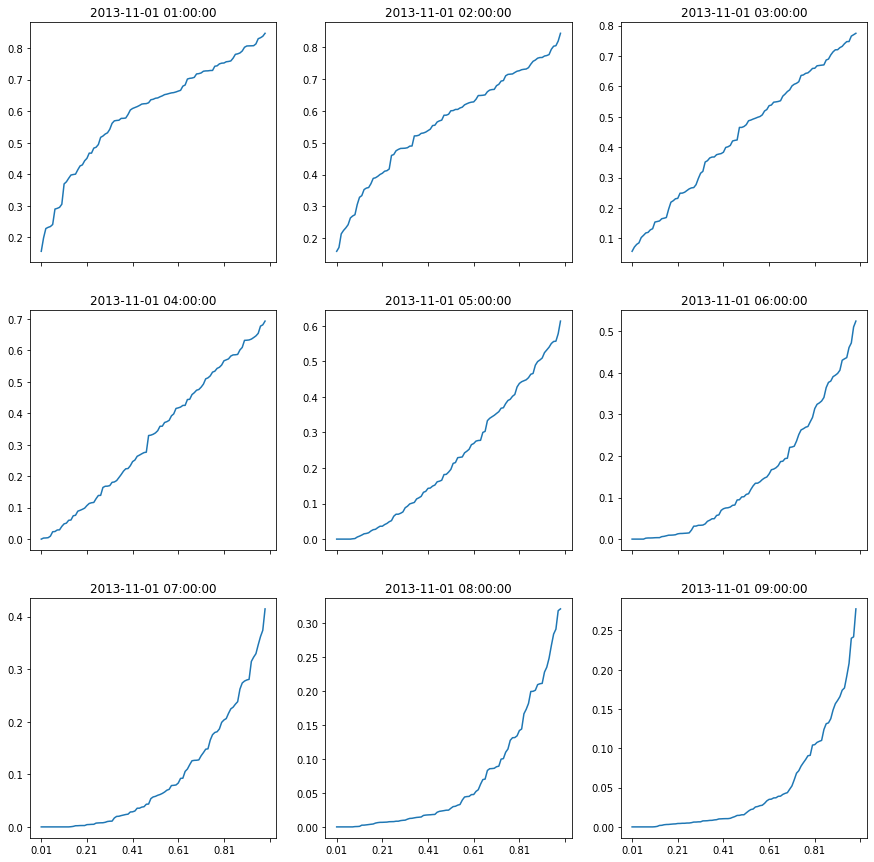

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, sharex=True, figsize=(15, 15))

for i in range(9):
    prediction.iloc[i].tail(99).plot(ax=ax[i // 3, i % 3],
                                     title=str(yq_output_df[-24*30:].index[i]))

# Evaluate Loss

The loss function is the pinnball loss:
$$ L(q_a, y) = \begin{cases}
    (1-\frac{a}{100})(q_a - y), &\text{if } y < q_a \\
    \frac{a}{100}(y-q_a), &\text{if } y \geq q_a.
\end{cases} $$

The score is then averaged over all target quantiles for all time periods over the forecast horizon and for all zones.

In [21]:
def pinnball_loss(actual, prediction):
    actual = actual[...,None]

    percentiles = np.empty((actual.shape[0], 99))
    for i in range(1, 100):
        percentiles[:, i-1] = i
    loss = np.where(actual < prediction,
                    (1 - percentiles / 100) * (prediction - actual),
                    percentiles / 100 * (actual - prediction))
    return loss

In [22]:
test_ts1 = np.squeeze(train_data_zones[0][-gefcom14_metadata['prediction_length']:].values)
test_ts2 = np.squeeze(train_data_zones[0][-gefcom14_metadata['prediction_length']:].values)
test_ts3 = np.squeeze(train_data_zones[0][-gefcom14_metadata['prediction_length']:].values)

prediction1 = prediction[prediction['ZONEID'] == 1].drop(columns='ZONEID')
prediction2 = prediction[prediction['ZONEID'] == 2].drop(columns='ZONEID')
prediction3 = prediction[prediction['ZONEID'] == 3].drop(columns='ZONEID')

loss1 = np.mean(pinnball_loss(test_ts1, prediction1))
loss2 = np.mean(pinnball_loss(test_ts2, prediction2))
loss3 = np.mean(pinnball_loss(test_ts3, prediction3))

loss = (loss1 + loss2 + loss3) / 3

print(f"Loss of task {task} with NNQF: {round(loss, 5)}")

Loss of task 9 with NNQF: 0.0296
